In [2]:
import matplotlib.pyplot as plt
import numpy as np

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import




In [3]:
coords = np.load('abl1_site.pdb.npy')
coords.shape

(4, 42, 32, 32)

In [4]:
import Bio.PDB
import scipy as np
import pickle
# import UFSR_feature as ufsr
import time

AA = ["ALA", "CYS", "ASP", "GLU", "PHE", "GLY", "HIS", "ILE", "LYS", "LEU",
      "MET", "ASN", "PRO", "GLN", "ARG", "SER", "THR", "VAL", "TRP", "TYR"]
with open("../data/ligands/set_of_ligands.pickle", "rb") as input_file:
    set_of_ligands = pickle.load(input_file)

'''
Extraction tools
'''


def is_an_acceptable_ligand(residue):
    """
    :param residue: Biopython Residue
    :return: Boolean : Is the residue an acceptable ligand (no ion, not water?) plus is it in the ligand set ?
    """
    return residue.get_resname() not in (["HOH"] + AA) and residue.get_resname() in set_of_ligands


def find_ligands_residue(structure):
    """
    Faster to compute this way because of the fast parsing of the mmcif
    :param structure: Biopython structure
    :return: identifiers of all ligands in a structure
    """
    ret = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if is_an_acceptable_ligand(residue):
                    ret += [residue]
    return ret


def find_spatial_binding_pocket(structure, ligand, start_radius, max_radius, number_min):
    """
    Find the smaller pocket
    Find the neighborhood of each atom and get the intersection
    :param structure: Biopython structure to search
    :param ligand: Biopython residue
    :param start_radius: Radius to start with, should be small to avoid taking everything, big enough to not be empty
    :param max_radius: The radius to stop to
    :param number_min: The cutoff under which one needs to stop picking neighbors
    :return:
    """
    searcher = Bio.PDB.NeighborSearch(list(structure.get_atoms()))
    neighbors = set()
    # Start by picking the neighbors closer to start radius
    for atom in ligand.get_atoms():
        center = np.array(atom.get_coord())
        radius = start_radius
        atom_result = []
        # Get the number_min neighbors of each point by increasing the start_radius while the max_radius wasn't reached
        while len(atom_result) < number_min and radius < max_radius:
            # Start the search with the given center and radius
            atom_result = []
            atom_neighbors = searcher.search(center, radius)
            # Filter out atoms part of water or pocket residue
            for atom_neighbor in atom_neighbors:
                residue = atom_neighbor.get_parent()
                if residue != ligand and residue.get_resname() != 'HOH':
                    atom_result.append(atom_neighbor)
            radius += 1
        for neighbor in atom_result:
            neighbors.add(neighbor)
    return neighbors


def pocket_to_array(neighbors):
    return np.array([atom.get_coord() for atom in neighbors])


In [118]:
parser = Bio.PDB.PDBParser(QUIET=True)
input_path = 'abl1_site.pdb'
structure = parser.get_structure(name, input_path)
binding_pocket = list(structure.get_atoms())


In [119]:
atom_coords = pocket_to_array(binding_pocket)


In [136]:
import multiprocessing as mlt
import Bio.PDB
import os
import time
import csv
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
grid_size=(32,29,22)

def coords_to_eigencoords(coords, n_components=3):
    """
    PCA base decomposition for this point set, includes centering
    :param array: array of 3D coordinates [n_samples, [x,y,z]]
    :return: same format but in the eigen_base
    """
    pca = PCA(n_components=n_components)
    coords_eigen = pca.fit_transform(coords)
    ampli = (np.max(coords_eigen, axis=0) - np.min(coords_eigen, axis=0))
    print(ampli)
    print(pca)
    return coords_eigen, pca


# coords = np.array([[1, 2], [3, 7], [6, 5], [7, 8]], dtype=float)
# t1 = time.time()
# coords_eigen = coords_to_eigencoords(coords, n_components=2)
# print(time.time() - t1)
# coords -= np.mean(coords, axis=0)
# # centering is part of the PCA routine
# plt.scatter(coords[:, 0], coords[:, 1])
# plt.scatter(coords_eigen[:, 0], coords_eigen[:, 1])
# plt.show()


def closest_grid_points(point, grid_size=None):
    """
    TODO :For now it is only working with 1Angstrom Grid pace
    :param point: np.array
    :param grid_size: Should be the angstrom resolution
    :return:
    """
    return point.astype(int)


# FIXME : round 2.7 to 3 please
# print(closest_grid_points(np.array([-2.7, 2, 1])))

mapping = {'C': 0,
           'O': 1,
           'N': 2,
           'S': 3}


def eigen_coords_to_tensor(eigen_coords, list_labels, grid_size):
    """
    Convert coords to tensor
    :param eigen_coords: coords in eigen vector base
    :param list_labels: labels attached to each point that needs to be attached to each point in space
    :param grid_size: tuple as the shape of the 3D grid
    :return:
    """
    valid = 0
    if not len(eigen_coords) == len(list_labels):
        raise ValueError('Not every points has a label...')
    tensor = np.zeros((len(mapping), *grid_size), dtype=np.int8)
    # move data to put center in the middle of grid :
    eigen_coords += np.array(grid_size) / 2
    for i, coords in enumerate(eigen_coords):
        label = list_labels[i]
        # skip if the associated label is not in the mapping function
        try:
            label_encoding = mapping[label]
        except KeyError:
            continue

        # Get the coordinate on the grid
        grid_coords = closest_grid_points(coords, grid_size)

        # One hot encode it, if it lies out of the grid, drop it
        tensor_coords = label_encoding, *grid_coords
        try:
            tensor[tensor_coords] += 1
            valid += 1
        except IndexError:
            continue
    return tensor, valid


# coords = np.array([[1, 2, 3], [3, 7, 3], [6, 5, 5], [7, 8, 80]], dtype=float)
# coords_eigen = coords_to_eigencoords(coords, n_components=3)
# list_labels = ['O', 'C', 'T', 'N']
# tensor, valid = eigen_coords_to_tensor(coords_eigen, list_labels, (10, 10, 10))
# # print(tensor, valid)
# print(tensor.shape)
# print(np.sum(tensor))




In [146]:
coords, labels = [], []
for i,atom in enumerate(binding_pocket):
    if i%20 == 0:
        if atom.parent.get_id()[0] == ' ':
            coords.append(atom.coord)
            labels.append(atom.element)
coords -= np.mean(coords, axis=0)
coords_eigen,pca = coords_to_eigencoords(np.array(coords))
print(pca.components_)  
tensor, valid = eigen_coords_to_tensor(coords, labels, grid_size)
eigen_tensor, valid = eigen_coords_to_tensor(coords_eigen, labels, grid_size)



[28.831375 27.032875 20.999657]
PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
[[-0.8801894  -0.46087766  0.11339475]
 [ 0.19298495 -0.12925287  0.97265124]
 [-0.43361664  0.87800074  0.20270947]]


In [214]:
import seaborn as sns
pal_atom = ['#b04a4b', '#cb4a4b','#ea4a4b','#ff4a4b']
#pal_atom = [0.2,0.4,0.6,0.8]
#pal_atom = list(reversed(sns.light_palette("red")))
#pal_axes = list(reversed(sns.light_palette("blue")))
#pal_axes = list(reversed(sns.color_palette("husl", 8)))

pal_axes = ["#ff4dff", "#0099ff", "#2ecc71"]


In [215]:
mapping ={'C': 0,
           'O': 1,
           'N': 2,
           'S': 3}

mapping_color ={'C': 'red','O': 'blue','N': 'green','S': 'black'}
mapping_color ={key : pal_atom[value] for key, value in mapping.items()}
print(mapping_color)



def create_voxels(coords):
    idxs = dict()
    for atom, code in mapping.items():
        idxs[atom] = coords[code,:,:,:]>0
      
        #print((coords[code,:,:,:]>0).shape)

    # combine the objects into a single boolean array
    voxels = np.sum(list(idxs.values()),axis=0)
    # print(voxels.shape)

    # set the colors of each object
    colors = np.empty(voxels.shape, dtype=object)
    for atom, color in mapping_color.items():
        colors[idxs[atom]]=color
    return voxels, colors

{'C': '#b04a4b', 'O': '#cb4a4b', 'N': '#ea4a4b', 'S': '#ff4a4b'}


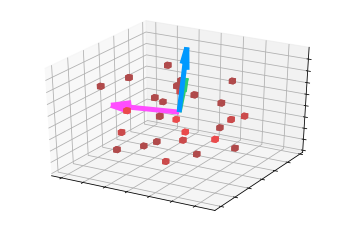

In [220]:
def tensor_to_axes(voxels,colors, vectors=[[1,0,0],[0,1,0],[0,0,1]]):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    #ax.set_axis_off()
    #ax.set_frame_on(False)
    #ax.tick_params(axis='both',bottom=False, top=False, left=False, right=False )
    ax.w_xaxis.set_ticklabels([''])
    ax.w_yaxis.set_ticklabels([''])
    ax.w_zaxis.set_ticklabels([''])
    ax.voxels(voxels, facecolors=colors, edgecolor=None)
    #ax.voxels.set_alpha(0.3)
    origin = [dim/2 for dim in grid_size]
    center = [origin for i in range(3)]
    ax.quiver3D(*origin, *vectors[0],length=13,color= pal_axes[0],linewidth=5)
    ax.quiver3D(*origin, *vectors[1],length=15,color= pal_axes[1],linewidth=5)
    ax.quiver3D(*origin, *vectors[2],length=13,color= pal_axes[2],linewidth=5)

    
voxels, colors = create_voxels(tensor)
tensor_to_axes(voxels,colors,pca.components_)
plt.savefig('unaligned.png',dpi=400)
plt.show()

In [221]:
def flip(tensor, i):
    """
    :param tensor: the tensor to rotate, a pytorch tensor
    :param i: integer between 0 and 7 the rotation is encoded as follow 7 in base 2 return a4 + b2 + c1 with abc
    indicating the presence of a rotation eg : 6 = 4 + 2 = 110 so it represents the flip along the first two axis
    :return: flipped tensor
    """
    if i == 0:
        return tensor, ()
    assert -1 < i < 8
    axes = []
    if i >= 4:
        axes.append(0)
        i -= 4
    if i >= 2:
        axes.append(1)
        i -= 2
    if i > 0:
        axes.append(2)
    tensor = np.flip(tensor, axis=axes)
    return (tensor, axes)

[0, 1, 2]
[0, 1]
[0, 2]
[0]
[1, 2]
[1]
[2]
()


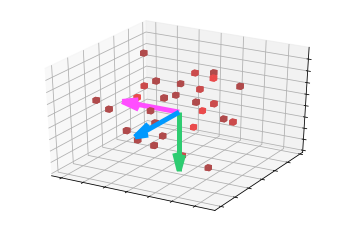

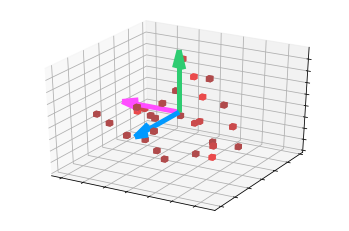

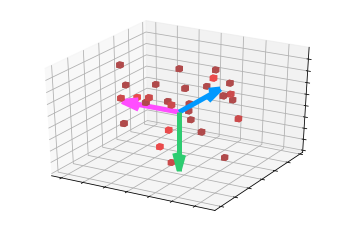

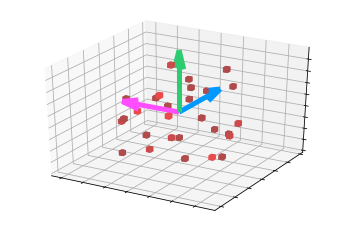

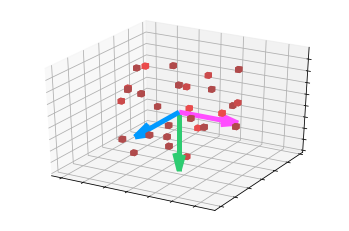

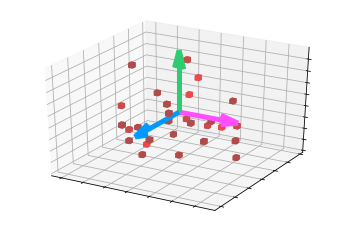

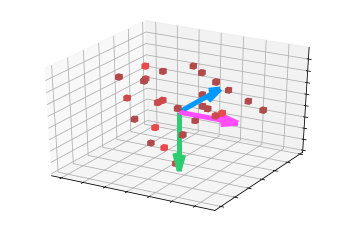

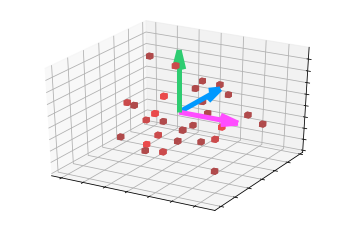

In [222]:
voxels, colors = create_voxels(eigen_tensor)
base_vectors=np.array([[1,0,0],[0,1,0],[0,0,1]])

for i in reversed(range(8)):
    temp_voxel, axes = flip(voxels,i)
    print(axes)
    temp_color,_ = flip(colors,i)
    temp_vector = base_vectors.copy()
    for flip_idx in axes:
        temp_vector[flip_idx] = -temp_vector[flip_idx]
    tensor_to_axes(temp_voxel,temp_color,temp_vector)
    plt.savefig(f'aligned_{i}.png',dpi=400)
#plt.show()